In [1]:
import pandas as pd
import yaml
import pickle
import os
import logging
from utilities.utilities import *
from utilities.plotting import plot_exposure_contour, plot_gdp_increase_scatter
from utilities.plotting import plot_variable_map, plot_cdd_scatter, plot_variable_histogram, plot_income_groups
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from scipy.stats import pearsonr

In [2]:
# Load configuration from config.yaml
with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)
logging.basicConfig(level=config['logging_level'])

# Read in often used values from config
with open('exposure_function_params_{0}.pkl'.format(config['availability_function']), 'rb') as f:
    params = pickle.load(f)

if config['availability_function'] == 'power_law':
    avail_func = power_avail
elif config['availability_function'] == 'exponential':
    avail_func = exp_avail
elif config['availability_function'] == 'combined_exponential':
    avail_func = None
else:
    raise ValueError('Availability function not recognized')

ref_year = config['analysis_years']['ref_year']
past_year = config['analysis_years']['past_year']
future_year = config['analysis_years']['future_year']

outfile_path = config['output_path']

# Read in income groups from World Bank data
income_groups = pd.read_excel(config['world_bank_income_groups_file'])
income_groups = income_groups[['Code', 'Income group']]

In [3]:
def exposure_new(cdd, gdp):
    if avail_func is not None:
        return exposure_function((cdd, gdp), avail_func, params['alpha'], params['beta'], params['gamma'])
    else:
        return exposure_combined_exponential((cdd, gdp), params['alpha'], params['beta'], params['gamma'])

In [4]:
# Collect country-level data, only recalculate if the file does not exist

if os.path.exists(outfile_path):
    logging.info('Reading in experienced temperature data from file {}'.format(outfile_path))
    # Read in the data
    ac_data = pd.read_csv(outfile_path)

else:
    logging.info('Cooling deficit Index analysis results not found, recalculating')

    # Read the historical cooling degree days data
    cdd_data = read_cdd_data(config['cdd_historical_file'])
    

    # Read the historical GDP data
    gdp_data = read_gdp_data(config['gdp_historical_file'])
    gdp_data_years = []
    for year in [past_year, ref_year]:
        gdp_data_year = gdp_data[gdp_data['Year'] == year]
        fill_missing_country_gdp_data(year, gdp_data_year, config)
        if year == past_year:
            gdp_data_year = gdp_data_year.rename(columns={'GDP': 'GDP_past'})
            gdp_data_year = gdp_data_year.rename(columns={'Year': 'Year_past'})
        gdp_data_years.append(gdp_data_year)
    gdp_data = pd.merge(gdp_data_years[0], gdp_data_years[1], on='ISO3')

    ac_data_historical = pd.merge(cdd_data, gdp_data, on=['ISO3', 'Year'], how='left')
    ac_data_historical = ac_data_historical.rename(columns={'Year': 'Year_ref'})
        
    # Add historical annual GDP growth
    ac_data_historical['gdp_historical_growth'] = calculate_average_gdp_growth(ac_data_historical['GDP'], 
            ac_data_historical['GDP_past'], ac_data_historical['Year_ref'] - ac_data_historical['Year_past'])

    # Add predictions for CDD in 2100 in different scenarios
    cdd_projections = read_projections(config, 'cdd', ac_data_historical, year=config['analysis_years']['future_year'])
    
    # Combine historical and projections into one dataframe
    ac_data = pd.merge(ac_data_historical, cdd_projections, on='ISO3', how='outer')

    # Formatting
    # Drop rows where year past is NaN
    ac_data = ac_data.dropna(subset=['Year_past'])
    ac_data.reset_index(drop=True, inplace=True)
    ac_data['Year_past'] = ac_data['Year_past'].astype(int)
    # Replace infinities with empty values
    ac_data = ac_data.replace(np.inf, np.nan)

    # Add column for historical heat exposure
    ac_data['exposure_times_cdd'] = exposure_new(ac_data['CDD'], ac_data['GDP'])*ac_data['CDD']
    ac_data['ac_adoption'] = 1. - exposure_new(ac_data['CDD'], ac_data['GDP'])

    # Sort by income quantile and label each country with income group
    ac_data = pd.merge(ac_data, income_groups, left_on='ISO3', right_on='Code', how='left').rename(columns={'Income group': 'income_group'})
    # Drop Code
    ac_data = ac_data.drop(columns=['Code'])
    # Income group names drop 'income' and make lower
    ac_data['income_group'] = ac_data['income_group'].str.replace(' income', '').str.lower()
    
    # Calculate GDP needed to keep heat exposure constant
    ac_data = calculate_gdp_const(ac_data, config, params)
    
print(ac_data)



INFO:root:Reading in experienced temperature data from file data/cooling_deficit_index_calculations.csv


     Unnamed: 0 ISO3               Country         CDD  Year_ref  Year_past  \
0             0  ABW                 Aruba  3232.42202      2019       1990   
1             1  AFG           Afghanistan   876.75506      2019       2002   
2             2  AGO                Angola  2169.94281      2019       1990   
3             3  ALB               Albania   630.35247      2019       1990   
4             4  ARE  United Arab Emirates  3865.06517      2019       1990   
..          ...  ...                   ...         ...       ...        ...   
203         203  XKX                Kosovo   371.80004      2019       2008   
204         204  YEM                 Yemen  2152.03753      2019       1990   
205         205  ZAF          South Africa   824.97062      2019       1990   
206         206  ZMB                Zambia  1596.08778      2019       1990   
207         207  ZWE              Zimbabwe  1442.73567      2019       1990   

          GDP_past           GDP  gdp_historical_gr

In [5]:
# Get income group averages of CDD and GDP
ac_data_income_group = ac_data[['Country', 'CDD', 'GDP', 'income_group']]
ac_data_income_group = ac_data_income_group.dropna()
print("\n##################")
print("Countries dropped when grouping by income group due to missing GDP/CDD/income_group:\n", ac_data[~ac_data['Country'].isin(ac_data_income_group['Country'])]['Country'].values)
print("##################\n")
ac_data_income_group = ac_data_income_group.drop(columns=['Country'])
ac_data_income_group = ac_data_income_group.groupby('income_group').median()

# Recalculate exposure times CDD for income groups
ac_data_income_group['exposure_times_cdd'] = exposure_new(ac_data_income_group['CDD'], ac_data_income_group['GDP'])*ac_data_income_group['CDD']

# # Calculate GDP needed to keep exposure times CDD constant
# for scenario in config['future_scenarios']:
#     ac_data_income_group = calculate_gdp_const(ac_data_income_group, config, params)

print("\n##################")
print("Income group median values: ")
print(ac_data_income_group)
print("##################\n")

# Add column to ac_data for GDP needed to get everyone to the exposure times cdd of the high income group
ac_data = calculate_gdp_const(ac_data, config, params, exp_cdd=ac_data_income_group.loc['high', 'exposure_times_cdd'])

# Write full dataframe to csv
if not os.path.exists(outfile_path):
    ac_data.to_csv(outfile_path)

/Users/awongel/Projects/clab_experiencedT/utilities/utilities.py:223: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  GDP_solutions[i] = fsolve(equation, initial_guess, args=(exposure_cdd[i], cdd[i]))[0]
/Users/awongel/Projects/clab_experiencedT/utilities/utilities.py:211: RuntimeWarning: invalid value encountered in power
  return np.exp(-alpha * ((CDD / 1e3) ** (beta * GDP / 1e6) * (GDP / 1e6) ** gamma))*CDD - f
INFO:root:Infinite GDP calculated for Index([], dtype='int64'), possibly 0 CDD
/Users/awongel/Projects/clab_experiencedT/utilities/utilities.py:223: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  GDP_solutions[i] = fsolve(equation, initial_guess, args=(exposure_cdd[i], cdd[i]))[0]
/Users/awongel/Projects/clab_experiencedT/utilities/utilities.py:211: RuntimeWarning: invalid value encountered in power
  return np.exp(-alpha *


##################
Countries dropped when grouping by income group due to missing GDP/CDD/income_group:
 ['American Samoa' 'Cuba' 'Eritrea' 'Faeroe Islands' 'Greenland' 'Guam'
 'Isle of Man' 'Northern Mariana Islands' 'New Caledonia'
 "Democratic People's Republic of Korea" 'French Polynesia' 'South Sudan'
 'Syrian Arab Republic' 'Bolivarian Republic of Venezuela'
 'United States Virgin Islands' 'Yemen']
##################


##################
Income group median values: 
                      CDD           GDP  exposure_times_cdd
income_group                                               
high           772.913080  41696.896380          326.366341
low           3003.843140   1655.843250         2957.370217
lower middle  2639.293605   5207.956634         2462.411062
upper middle  1725.610740  14851.648588         1314.822903
##################



In [6]:
# Get the color on the GDP map for each income group in RGB
cmap = plt.cm.get_cmap(config['plotting']['gdp_cmap'])
norm = mcolors.LogNorm(vmin=config['plotting']['gdp_min'], vmax=config['plotting']['gdp_max'])
ac_data_income_group['gdp_color'] = ac_data_income_group['GDP'].apply(lambda x: mcolors.rgb2hex(cmap(norm(x))))
print("\n##################")
print("Colors for income groups used in plots:")
print(ac_data_income_group['gdp_color'])
print("##################\n")


##################
Colors for income groups used in plots:
income_group
high            #81d34d
low             #482878
lower middle    #2e6e8e
upper middle    #20a486
Name: gdp_color, dtype: object
##################



In [7]:
# Add CDD difference between 2100 and ref year
for scenario in config['future_scenarios']:
    ac_data['CDD_{0}_{1}_diff'.format(scenario, future_year)] = ac_data['CDD_{0}_{1}'.format(scenario, future_year)] - ac_data['CDD']
    # ac_data_income_group['CDD_{0}_{1}_diff'.format(scenario, future_year)] = ac_data_income_group['CDD_{0}_{1}'.format(scenario, future_year)] - ac_data_income_group['CDD']

In [8]:
print("NUMERICAL VALUES QUOTED IN PUBLICATION:\n")

print("\n##################")
print("\nRelated to Fig.1")
ac_data_no_nans = ac_data.dropna(subset=['CDD', 'GDP'])
corr = pearsonr(ac_data_no_nans['CDD'], ac_data_no_nans['GDP'].apply(np.log))[0]
p_value = pearsonr(ac_data_no_nans['CDD'], ac_data_no_nans['GDP'].apply(np.log))[1]
# Print countries with CDD diff nan
ac_data_no_nans = ac_data_no_nans.dropna(subset=['CDD_ssp2_rcp45_2100_diff', 'GDP'])
corr_diff = pearsonr(ac_data_no_nans['CDD_ssp2_rcp45_2100_diff'], ac_data_no_nans['GDP'].apply(np.log))[0]
p_value_diff = pearsonr(ac_data_no_nans['CDD_ssp2_rcp45_2100_diff'], ac_data_no_nans['GDP'].apply(np.log))[1]
print("Correlation of CDD and log of GDP: {}, with p-value: {}".format(corr, p_value))
print("Correlation of CDD increase and GDP: {}, with p-value: {}".format(corr_diff, p_value_diff))

# Minimum and maximum CDD for low income group, round to integer
print("\n##################")
print("\nRelated to Fig.2")
print("Average CDD increase for all countries: {}".format(ac_data['CDD_ssp2_rcp45_2100_diff'].mean()))
print("Minimum CDD for low income group: {}".format(ac_data[ac_data['income_group'] == 'low']['CDD'].min()))
print("Maximum CDD for low income group: {}".format(ac_data[ac_data['income_group'] == 'low']['CDD'].max()))
print("Maximum CDD increase for low income group: {}".format(ac_data[ac_data['income_group'] == 'low']['CDD_ssp2_rcp45_2100_diff'].max()))
# Countries of low income group with less than 500 CDD diff
print("Countries of low income group with less than 500 CDD increase: ", ac_data[(ac_data['income_group'] == 'low') & (ac_data['CDD_ssp2_rcp45_2100_diff'] < 500)]['Country'].values)
print("##################\n")

print("\n##################")
print("\nRelated to Fig.3")
# Print GDP increase for low income group to get to today's high income CDI
print("GDP factor for low income group to get to today's high income CDI: {}".format(gdp_from_cdd_exposure(ac_data_income_group.loc['high', 'exposure_times_cdd'], [ac_data_income_group.loc['low', 'CDD']], params)/ac_data_income_group.loc['low', 'GDP']))
print("##################\n")

print("\n##################")
print("\nRelated to Fig.4")
# Print GDP factor getting CDI to high income value over avoiding CDI increase
growth_ratio = ac_data[ac_data['income_group'] == 'low']['gdp_const_ssp2_rcp45_custom_exp_cdd']/ac_data[ac_data['income_group'] == 'low']['gdp_const_ssp2_rcp45']
print('GDP growth ratio of reaching high income CDI over avoiding increase in CDI for low income group: {}'.format(growth_ratio.mean()))
print('Low income group GDP growth rates: historical {}; to avoid increase in CDI {}; to reach high income CDI {}'
      .format(ac_data[ac_data['income_group'] == 'low']['gdp_historical_growth'].mean(), ac_data[ac_data['income_group'] == 'low']['gdp_const_ssp2_rcp45'].mean(), 
              ac_data[ac_data['income_group'] == 'low']['gdp_const_ssp2_rcp45_custom_exp_cdd'].mean()))
print("##################\n")

print("\n##################")
print("\nRelated to Methods")
# Countries with CDD smaller than the projection
print("Countries with CDD smaller than the projection in 2100 for SSP2 RCP 4.5:")
print(ac_data[ac_data['CDD_ssp2_rcp45_2100'] < ac_data['CDD']]['Country'].values)
print("Countries with CDD smaller than the projection in 2100 for SSP1 RCP 2.6:")
print(ac_data[ac_data['CDD_ssp1_rcp26_2100'] < ac_data['CDD']]['Country'].values)
print("Countries with CDD smaller than the projection in 2100 for SSP5 RCP 6.0:")
print(ac_data[ac_data['CDD_ssp5_rcp60_2100'] < ac_data['CDD']]['Country'].values)
print("##################\n")

NUMERICAL VALUES QUOTED IN PUBLICATION:


##################

Related to Fig.1
Correlation of CDD and log of GDP: -0.36879848399627996, with p-value: 1.4127694712228866e-07
Correlation of CDD increase and GDP: -0.5265898412354599, with p-value: 3.7353534499691634e-13

##################

Related to Fig.2
Average CDD increase for all countries: 567.0226540229885
Minimum CDD for low income group: 532.02947
Maximum CDD for low income group: 3993.88824
Maximum CDD increase for low income group: 1200.99743
Countries of low income group with less than 500 CDD increase:  ['Afghanistan' 'Madagascar' "Democratic People's Republic of Korea"
 'Yemen']
##################


##################

Related to Fig.3
GDP factor for low income group to get to today's high income CDI: 0    32.620981
dtype: float64
##################


##################

Related to Fig.4
GDP growth ratio of reaching high income CDI over avoiding increase in CDI for low income group: 1.5932201048743377
Low income group GDP g

/Users/awongel/Projects/clab_experiencedT/utilities/utilities.py:211: RuntimeWarning: invalid value encountered in power
  return np.exp(-alpha * ((CDD / 1e3) ** (beta * GDP / 1e6) * (GDP / 1e6) ** gamma))*CDD - f


/Users/awongel/Projects/clab_experiencedT/utilities/plotting_classes.py:81: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/Users/awongel/Projects/clab_experiencedT/utilities/plotting_classes.py:81: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/Users/awongel/Projects/clab_experiencedT/utilities/plotting_classes.py:81: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downlo

<Figure size 640x480 with 0 Axes>

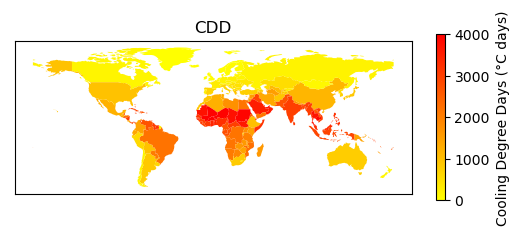

<Figure size 640x480 with 0 Axes>

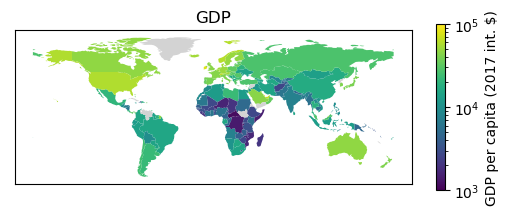

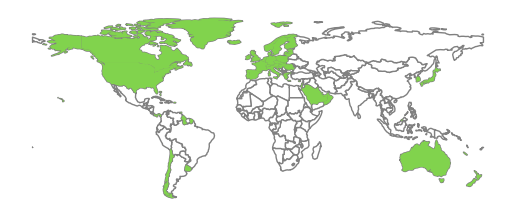

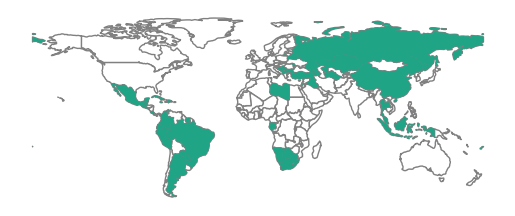

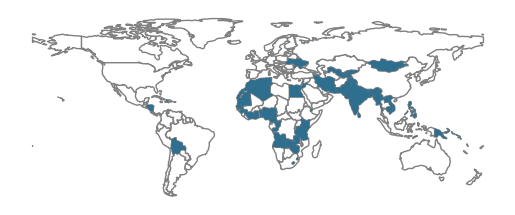

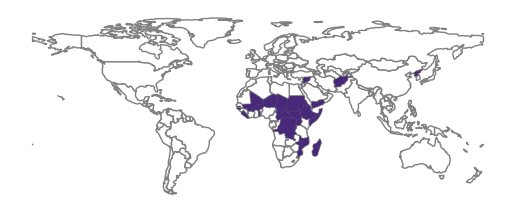

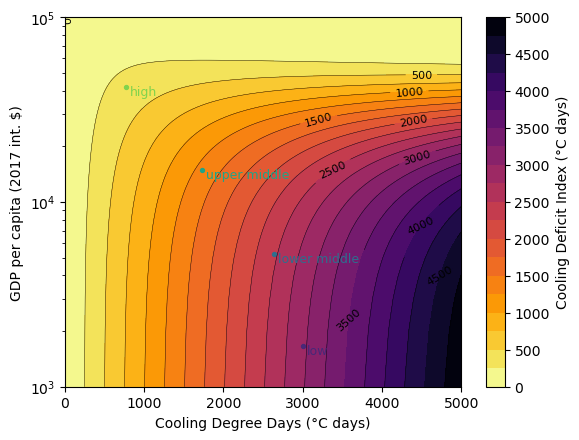

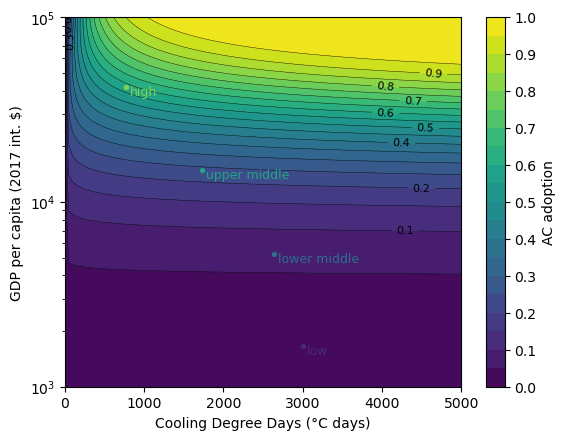

<Figure size 640x480 with 0 Axes>

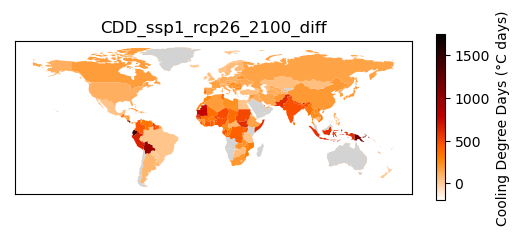

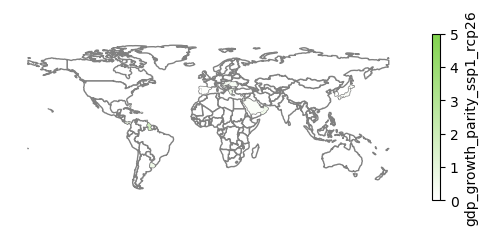

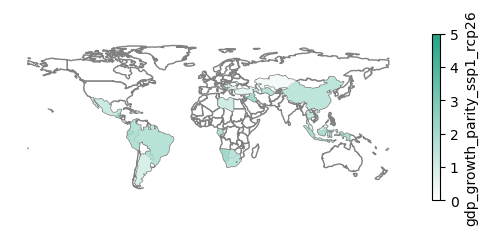

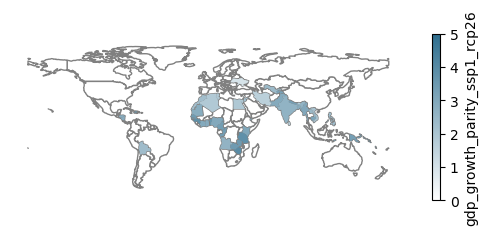

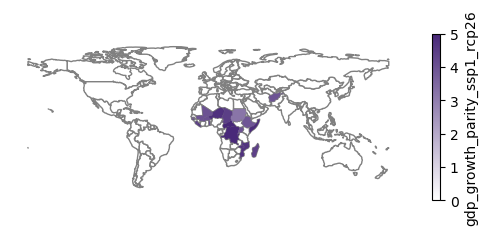

<Figure size 640x480 with 0 Axes>

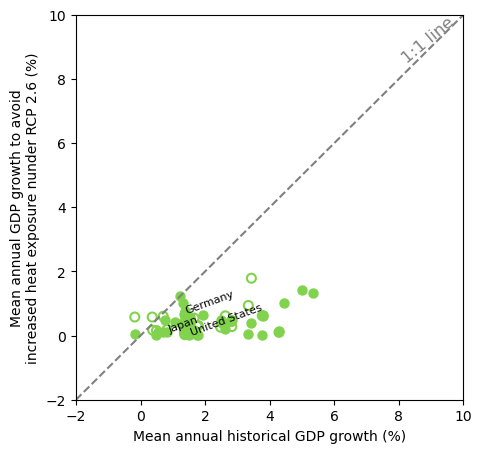

<Figure size 640x480 with 0 Axes>

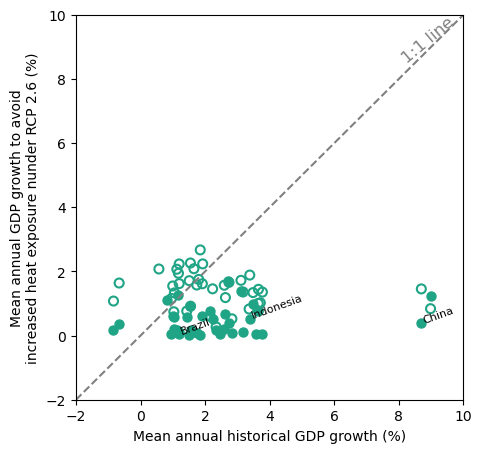

<Figure size 640x480 with 0 Axes>

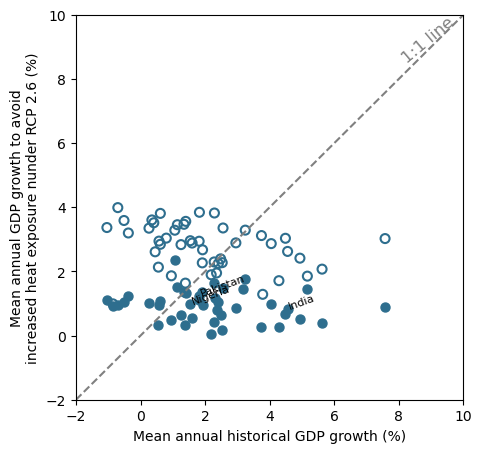

<Figure size 640x480 with 0 Axes>

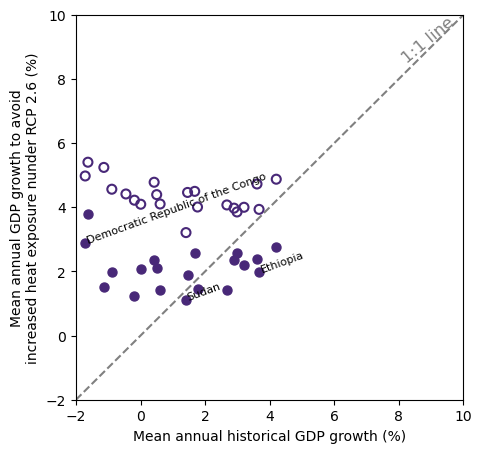

<Figure size 640x480 with 0 Axes>

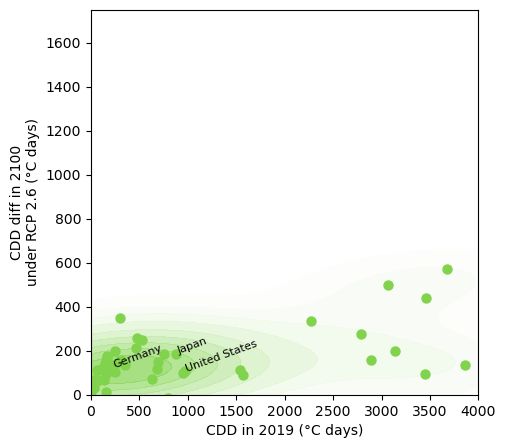

<Figure size 640x480 with 0 Axes>

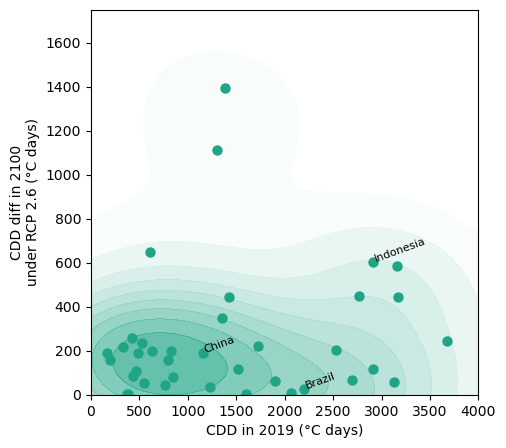

<Figure size 640x480 with 0 Axes>

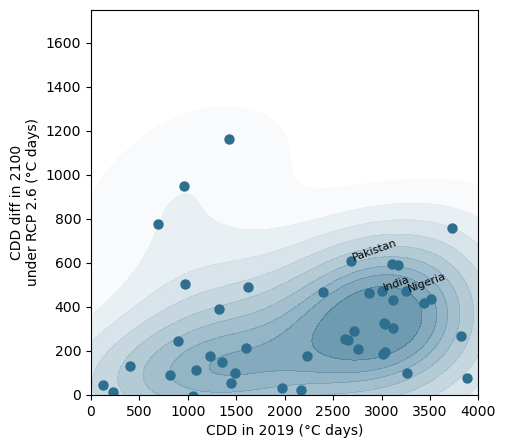

<Figure size 640x480 with 0 Axes>

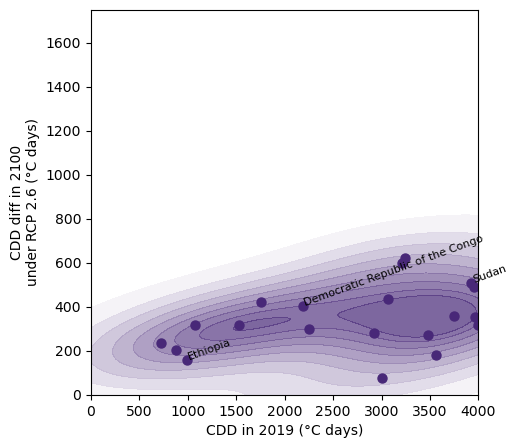

<Figure size 640x480 with 0 Axes>

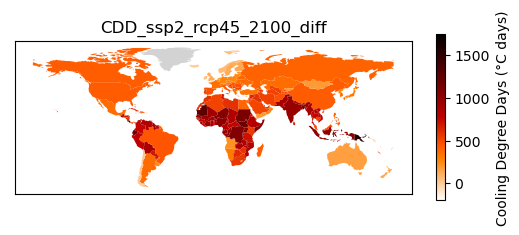

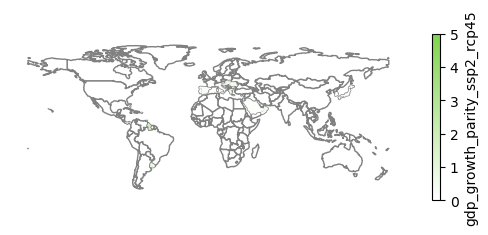

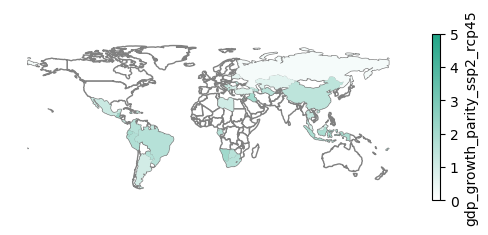

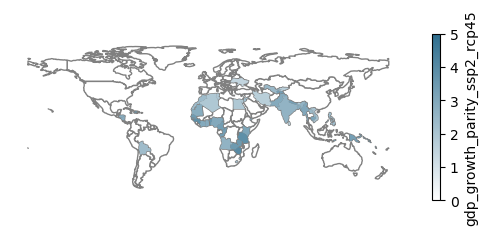

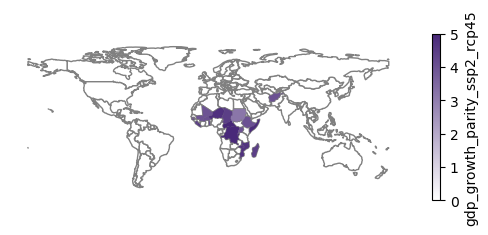

<Figure size 640x480 with 0 Axes>

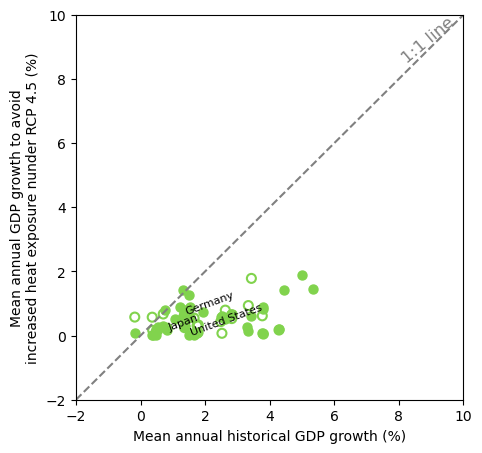

<Figure size 640x480 with 0 Axes>

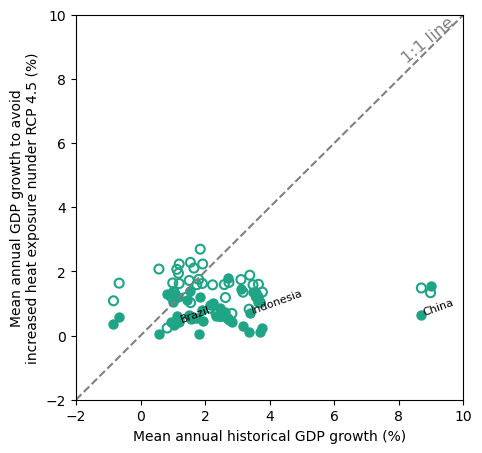

<Figure size 640x480 with 0 Axes>

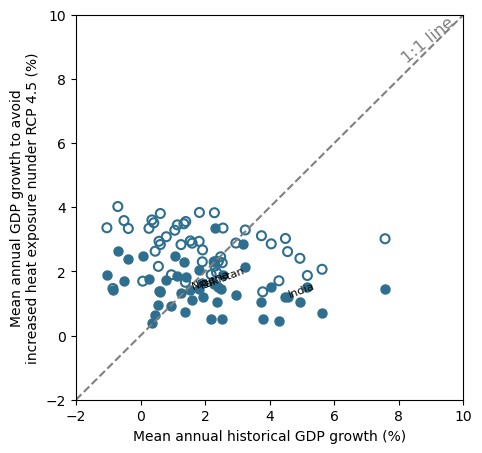

<Figure size 640x480 with 0 Axes>

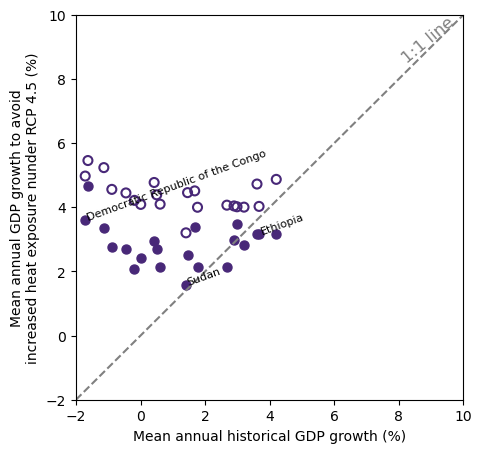

<Figure size 640x480 with 0 Axes>

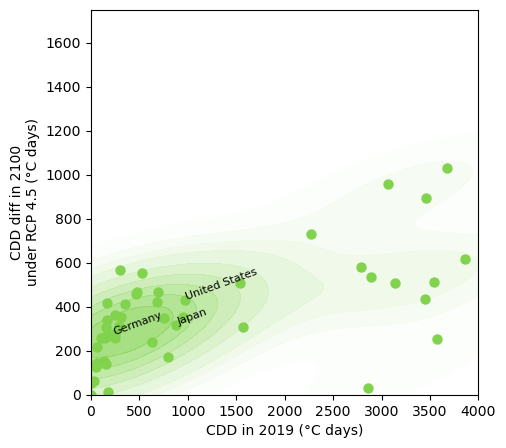

<Figure size 640x480 with 0 Axes>

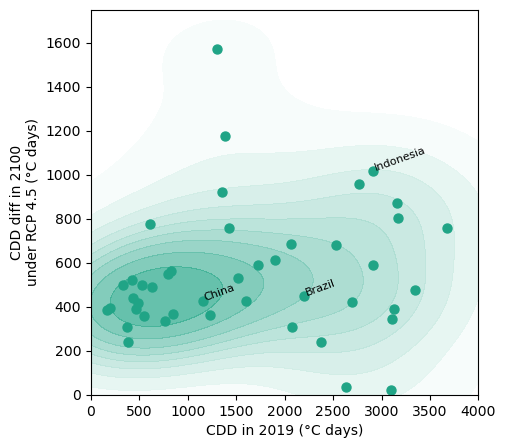

<Figure size 640x480 with 0 Axes>

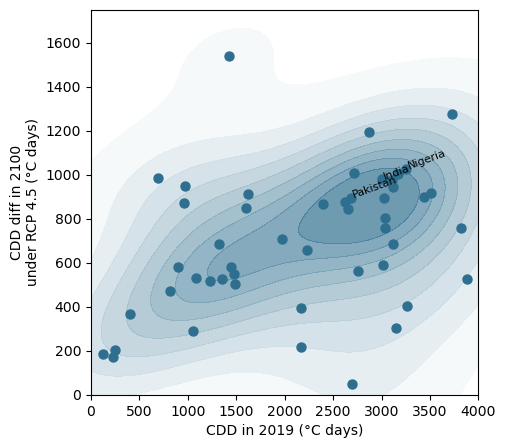

<Figure size 640x480 with 0 Axes>

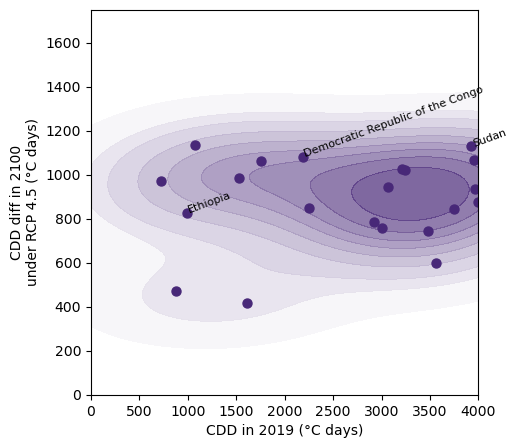

<Figure size 640x480 with 0 Axes>

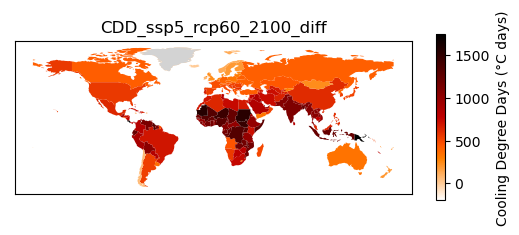

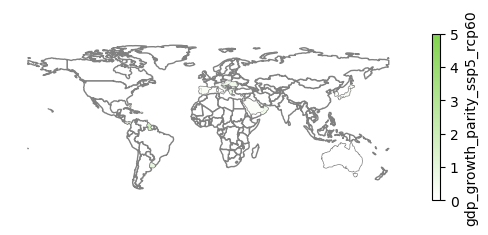

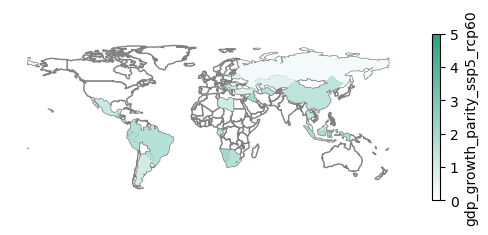

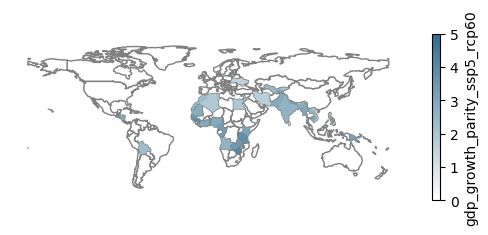

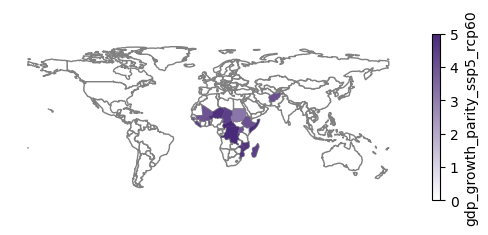

<Figure size 640x480 with 0 Axes>

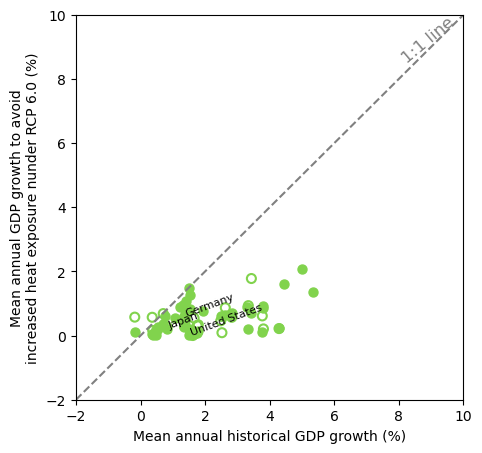

<Figure size 640x480 with 0 Axes>

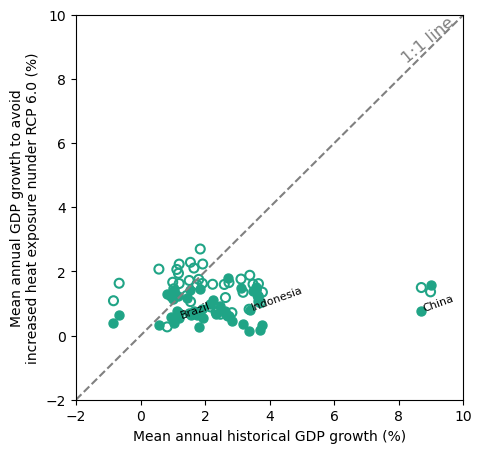

<Figure size 640x480 with 0 Axes>

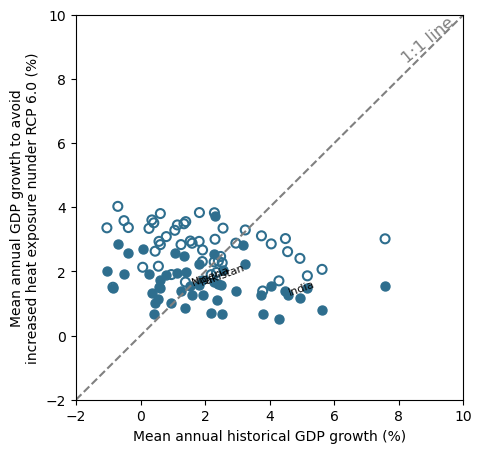

<Figure size 640x480 with 0 Axes>

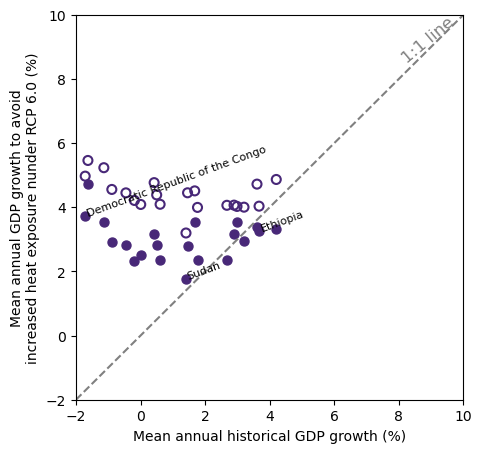

<Figure size 640x480 with 0 Axes>

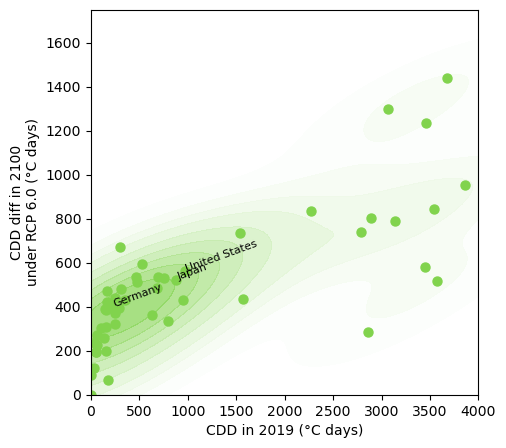

<Figure size 640x480 with 0 Axes>

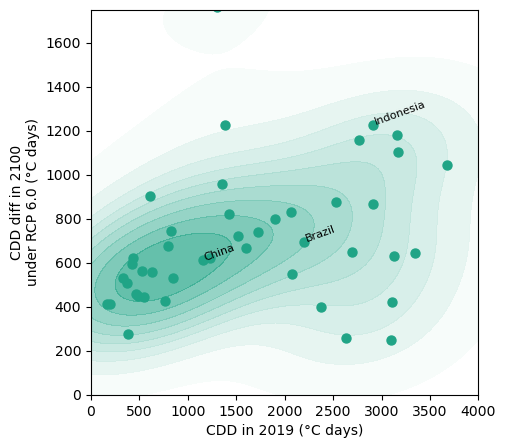

<Figure size 640x480 with 0 Axes>

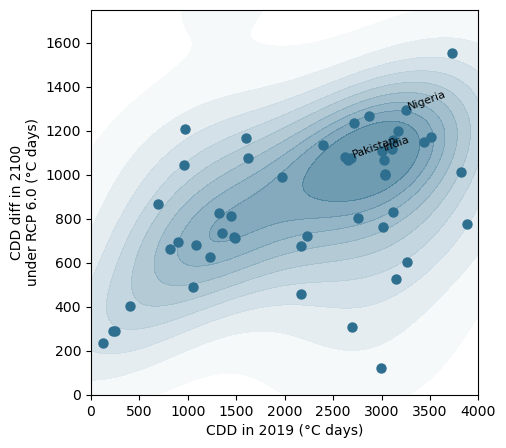

<Figure size 640x480 with 0 Axes>

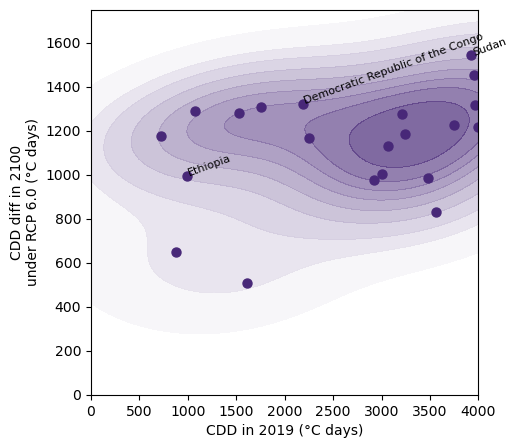

In [9]:
# Make all plots

for scenario in ['historical'] + config['future_scenarios']:

    # Parts of Figure CDD change (Fig.3)
    if scenario == 'historical':
        vars = ['CDD', 'GDP']
    else:
        vars = ['CDD_{}_2100_diff'.format(scenario)]
    
    # Figure GDP and CDD maps (Fig.1)
    for var in vars:
        plot_variable_map(config, ac_data, var)
    
    if scenario == 'historical':
        # Plot maps highlighting income groups (Fig.4)
        plot_income_groups(config, ac_data)
        # Figure Contours (Fig.2)
        xrange = [config['plotting']['cdd_min'], config['plotting']['cooling_deficit_index_max'], 100]
        yrange = [config['plotting']['gdp_min'], config['plotting']['gdp_max'], 100]
        # Exposure times CDD
        plot_exposure_contour(config, exposure_new, ac_data_income_group, 
            x_y_ranges=[xrange, yrange], name_tag='cooling_deficit_index_contour')
        # AC adoption
        plot_exposure_contour(config, exposure_new, ac_data_income_group, 
            x_y_ranges=[xrange, yrange], name_tag='AC_adoption_contour', multiply_cdd=False)
        continue

    # Plot maps with GDP needed to keep exposure divided by historical GDP growth (Fig.4)
    ac_data['gdp_growth_parity_{}'.format(scenario)] = (ac_data['gdp_const_{}_custom_exp_cdd'.format(scenario)]) * 100
    plot_income_groups(config, ac_data, 'gdp_growth_parity_{}'.format(scenario))

    # Part of Figure GDP growth (Fig.4)
    plot_gdp_increase_scatter(config, ac_data, scenario)

    # Part of Figure CDD change (Fig.3)
    plot_cdd_scatter(config, ac_data, scenario)